<a href="https://colab.research.google.com/github/Ishu2412/Curvetopia/blob/main/AdobeGensolve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install svgwrite
!pip install cairosvg
!pip install opencv-python
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
import cairosvg
import cv2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.0 MB/s eta 0:00:00


In [3]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!pip install opencv-python scikit-image
from skimage import measure, color
from skimage.draw import ellipse_perimeter
from google.colab.patches import cv2_imshow
from scipy.spatial.distance import cdist
import pandas as pd

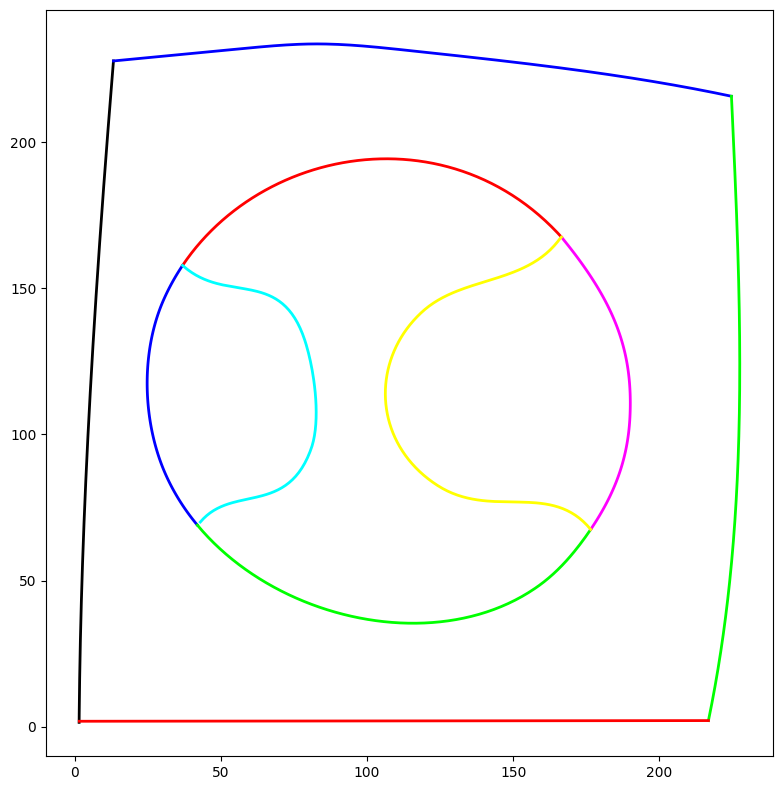

In [5]:
# 1. Reading CSV with pandas
def read_csv(csv_path):
    df = pd.read_csv(csv_path, header=None)
    path_XYs = [df[df[0] == i].iloc[:, 1:].groupby(1).apply(lambda g: g.iloc[:, 1:].values).tolist() for i in df[0].unique()]
    return path_XYs

# 2. Visualization with matplotlib
def plot(paths_XYs):
    colours = ['#0000ff', '#00ff00', '#ff0000', '#00ffff', '#ff00ff', '#ffff00', '#000000']
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# 3. Edge Detection and Contour Identification
def process_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# 4. Shape Identification
def identify_shapes(contours):
    shapes = []
    for contour in contours:
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 3:
            shapes.append("Triangle")
        elif len(approx) == 4:
            ar = cv2.boundingRect(approx)[2] / float(cv2.boundingRect(approx)[3])
            shapes.append("Square" if 0.95 <= ar <= 1.05 else "Rectangle")
        elif len(approx) > 4:
            ar = cv2.fitEllipse(contour)[1][0] / cv2.fitEllipse(contour)[1][1]
            shapes.append("Circle" if 0.95 <= ar <= 1.05 else "Ellipse")
        else:
            shapes.append("Unknown")
    return shapes

# 5. Symmetry Detection with scipy
def detect_symmetry(XY):
    mid_x, mid_y = np.mean(XY, axis=0)
    vertical_symmetry = is_symmetric_along_line(XY, (mid_x, 0), (mid_x, 1))
    horizontal_symmetry = is_symmetric_along_line(XY, (0, mid_y), (1, mid_y))
    symmetries = []
    if vertical_symmetry:
        symmetries.append('vertical')
    if horizontal_symmetry:
        symmetries.append('horizontal')
    return symmetries

def is_symmetric_along_line(XY, point1, point2):
    reflected = reflect_points(XY, point1, point2)
    return np.allclose(XY, reflected, atol=1e-2)

def reflect_points(XY, p1, p2):
    p1, p2 = np.array(p1), np.array(p2)
    return XY - 2 * np.dot(XY - p1, p2 - p1)[:, None] * (p2 - p1) / np.dot(p2 - p1, p2 - p1)

def find_symmetries(paths_XYs):
    symmetries = [(XY, detect_symmetry(XY)) for XYs in paths_XYs for XY in XYs]
    return symmetries

# 6. Curve Completion
def complete_curves(paths_XYs):
    return [[np.vstack([XY, XY[0]]) if not np.allclose(XY[0], XY[-1], atol=1e-2) else XY for XY in XYs] for XYs in paths_XYs]

# 7. Convert Polylines to SVG
def polylines2svg(paths_XYs, svg_path):
    W, H = np.max([np.max(XY, axis=0) for XYs in paths_XYs for XY in XYs], axis=0) * 1.1
    W, H = int(W), int(H)

    # Convert to strings with units
    W, H = f"{W}px", f"{H}px"

    dwg = svgwrite.Drawing(svg_path, size=(W, H), profile='tiny')
    group = dwg.g()

    colours = ['#0000ff', '#00ff00', '#ff0000', '#00ffff', '#ff00ff', '#ffff00', '#000000']

    for i, path in enumerate(paths_XYs):
        for XY in path:
            path_data = [("M", (XY[0, 0], XY[0, 1]))]
            path_data += [("L", (XY[j, 0], XY[j, 1])) for j in range(1, len(XY))]
            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))

            path_string = ''.join([f'{cmd} {x},{y} ' if cmd != "Z" else cmd for cmd, (x, y) in path_data if cmd != "Z"])
            group.add(dwg.path(d=path_string, fill=colours[i % len(colours)], stroke='none', stroke_width=2))

    dwg.add(group)
    dwg.save()

    cairosvg.svg2png(url=svg_path, write_to=svg_path.replace('.svg', '.png'))

# Example Usage
input_path = '/content/drive/MyDrive/frag0.csv'
paths_XYs = read_csv(input_path)
plot(paths_XYs)
contours = process_image('/content/drive/MyDrive/frag0.png')
detected_shapes = identify_shapes(contours)
symmetries = find_symmetries(paths_XYs)
completed_paths = complete_curves(paths_XYs)
polylines2svg(completed_paths, '/content/drive/MyDrive/completed_frag0.svg')


In [6]:
#detected shapes
print(detected_shapes)

['Unknown', 'Unknown', 'Unknown', 'Rectangle', 'Unknown', 'Ellipse', 'Rectangle', 'Ellipse', 'Unknown', 'Unknown']


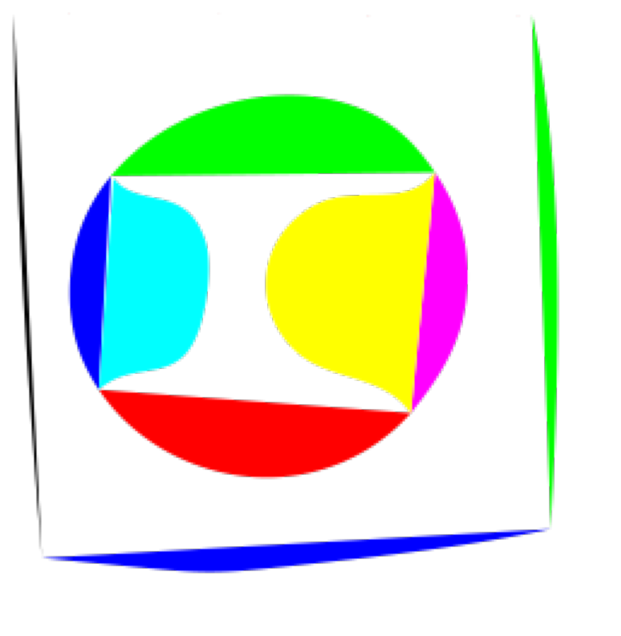

In [7]:
import matplotlib.image as mpimg

# Convert SVG to PNG
def convert_svg_to_png(svg_path, png_path):
    cairosvg.svg2png(url=svg_path, write_to=png_path)

# Visualize the PNG
def visualize_png(png_path):
    img = mpimg.imread(png_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# Example Usage
svg_path = '/content/drive/MyDrive/completed_frag0.svg'
png_path = '/content/drive/MyDrive/completed_frag0.png'

# Convert the SVG to PNG
convert_svg_to_png(svg_path, png_path)

# Visualize the PNG
visualize_png(png_path)